## ResNet50-fine-tuning-V1
整体说明：
- 使用keras的ResNet50预训练模型进行fine-tuning，分别进行下面四种情况的fine-tuning
- 1、只训练自定义的输出层
- 2、冻结前164层，训练后面的层
- 3、冻结前142层，训练后面的层
- 4、冻结前112层，训练后面的层  
看哪种情况效果最好



In [1]:
'''
数据目录结构：
data/
    train/    #原始数据，train.zip解压后生成
        dog.0.jpg
        cat.0.jpg
        ...
    train2/   #按标签分目录后的数据（连接文件）
        dog/
            dog.0.jpg
            dog.1.jpg
            ...
        cat/
            cat.0.jpg
            cat.1.jpg
            ...
    train3/   #去除异常图片后的训练数据（连接文件）
        dog/    #9983张图片
            dog.0.jpg
            dog.1.jpg
            ...
        cat/    #9961张图片
            cat.0.jpg
            cat.1.jpg
            ...
    validation/  #去除异常图片后的验证数据（连接文件）
        dog/   #2496张图片
            dog001.jpg
            dog002.jpg
            ...
        cat/   #2490张图片
            cat001.jpg
            cat002.jpg
            ...
    test/     
        test/  #测试集数据，12500张图片
            1.jpg
            2.jpg
            ...
'''
import cv2
import time
import pandas as pd
from tqdm import tqdm   #进度条
from PIL import Image
from helper import *

from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *
from keras.callbacks import *
from keras.optimizers import *
from keras.utils import *
from sklearn.utils import shuffle

# dimensions of our images.
img_width, img_height = 224, 224

train_data_dir = 'data/train2'
test_data_dir='data/test'


batch_size = 72   #19944/72=277  4986/72=69.25
epochs=20
VER=1
#模型权重文件
model_h5file_base="ResNet50-base-tuning-v{}.h5".format(VER)
model_h5file_tunig1="ResNet50-fine-tuning-1-v{}.h5".format(VER)
model_h5file_tunig2="ResNet50-fine-tuning-2-v{}.h5".format(VER)
model_h5file_tunig3="ResNet50-fine-tuning-3-v{}.h5".format(VER)

#预测结果文件
pred_file_base="pred-ResNet50-base-tuning-v{}.csv".format(VER)
pred_file_tuning1="pred-ResNet50-fine-tuning-1-v{}.csv".format(VER)
pred_file_tuning2="pred-ResNet50-fine-tuning-2-v{}.csv".format(VER)
pred_file_tuning3="pred-ResNet50-fine-tuning-3-v{}.csv".format(VER)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#构造InceptionResNetV2模型
start = time.clock()
x_input = Input((img_width, img_height, 3))
x_input = Lambda(resnet50.preprocess_input)(x_input)

base_model = ResNet50(input_tensor=x_input, weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3), pooling = 'avg')
for layer in base_model.layers:
    layer.trainable = False
    
y = Dropout(0.5)(base_model.output) #0.25-->0.5
y = Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(0.001))(y)  #增加正则项
model = Model(inputs=base_model.input, outputs=y)

print("Load base model used time:", (time.clock() - start))


Load base model used time: 9.571102


In [3]:
adam = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(optimizer=adam,
             loss='binary_crossentropy',
             metrics=['accuracy'])


In [4]:
# 输出模型结构图
# plot_model(model, to_file='model_ResNet50.png')

In [5]:
#生成数据--全量读入内存
#X_train, Y_train=read_images_to_memory(train_data_dir, img_width, img_height, test=True)
#训练数据
X_train, Y_train=read_images_to_memory(train_data_dir, img_width, img_height)
X_train, Y_train=shuffle(X_train, Y_train)

#测试数据
X_test = load_test_data(12500, img_height, img_width, test_data_dir)


  0%|          | 0/12479 [00:00<?, ?it/s]

dog_nums=12479, cat_nums=12451
total images: 24930


100%|██████████| 12500/12500 [01:17<00:00, 161.70it/s]


In [6]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           lambda_1[0][0]                   
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (

In [7]:
#训练模型并保存在验证集上损失函数最小的权重
checkpoint = ModelCheckpoint(model_h5file_base, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min') #如连续3个epoch,loss都没有没有下降,则停止训练
callbacks_list = [stopping,checkpoint]

history=model.fit(X_train, Y_train, batch_size=128, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=callbacks_list)

Train on 19944 samples, validate on 4986 samples
Epoch 1/20
19944/19944 [==============================] - 51s 3ms/step - loss: 0.6370 - acc: 0.6596 - val_loss: 0.3052 - val_acc: 0.8909

Epoch 00001: val_loss improved from inf to 0.30519, saving model to ResNet50-base-tuning-v1.h5
Epoch 2/20
19944/19944 [==============================] - 47s 2ms/step - loss: 0.3271 - acc: 0.8751 - val_loss: 0.1903 - val_acc: 0.9356

Epoch 00002: val_loss improved from 0.30519 to 0.19032, saving model to ResNet50-base-tuning-v1.h5
Epoch 3/20
19944/19944 [==============================] - 48s 2ms/step - loss: 0.2303 - acc: 0.9173 - val_loss: 0.1384 - val_acc: 0.9519

Epoch 00003: val_loss improved from 0.19032 to 0.13840, saving model to ResNet50-base-tuning-v1.h5
Epoch 4/20
19944/19944 [==============================] - 47s 2ms/step - loss: 0.1890 - acc: 0.9363 - val_loss: 0.1227 - val_acc: 0.9561

Epoch 00004: val_loss improved from 0.13840 to 0.12272, saving model to ResNet50-base-tuning-v1.h5
Epoch 5

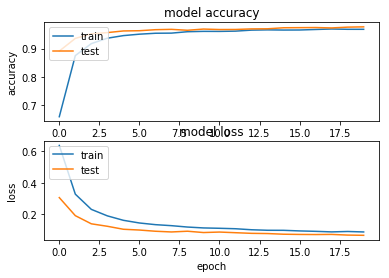

In [8]:
#可视化学习曲线
show_learning_curve(history)

In [9]:
#预测结果    
predict_on_model(X_test, model, model_h5file_base, pred_file_base)

12500/12500 [==============================] - 29s 2ms/step


  0%|          | 0/12500 [00:00<?, ?it/s]/home/ubuntu/dogs-and-cats/helper.py:151: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(i, 'label', y_test[i])
100%|██████████| 12500/12500 [00:00<00:00, 139727.79it/s]


## 冻结前164层，再训练
放开conv5_x最后一层以后的层，含conv5_x的最后一层  
164 activation_46

In [12]:
# 设置需要冻结的层数

def lock_layers(model, locked_layer_nums):
    for i in range(len(model.layers)):
        print(i,model.layers[i].name)
        model.layers[i].trainable = True
        
    for layer in model.layers[:locked_layer_nums]:  #冻结前N层
        layer.trainable = False   

        
lock_layers(model, locked_layer_nums=164)

0 input_1
1 lambda_1
2 conv1_pad
3 conv1
4 bn_conv1
5 activation_1
6 max_pooling2d_1
7 res2a_branch2a
8 bn2a_branch2a
9 activation_2
10 res2a_branch2b
11 bn2a_branch2b
12 activation_3
13 res2a_branch2c
14 res2a_branch1
15 bn2a_branch2c
16 bn2a_branch1
17 add_1
18 activation_4
19 res2b_branch2a
20 bn2b_branch2a
21 activation_5
22 res2b_branch2b
23 bn2b_branch2b
24 activation_6
25 res2b_branch2c
26 bn2b_branch2c
27 add_2
28 activation_7
29 res2c_branch2a
30 bn2c_branch2a
31 activation_8
32 res2c_branch2b
33 bn2c_branch2b
34 activation_9
35 res2c_branch2c
36 bn2c_branch2c
37 add_3
38 activation_10
39 res3a_branch2a
40 bn3a_branch2a
41 activation_11
42 res3a_branch2b
43 bn3a_branch2b
44 activation_12
45 res3a_branch2c
46 res3a_branch1
47 bn3a_branch2c
48 bn3a_branch1
49 add_4
50 activation_13
51 res3b_branch2a
52 bn3b_branch2a
53 activation_14
54 res3b_branch2b
55 bn3b_branch2b
56 activation_15
57 res3b_branch2c
58 bn3b_branch2c
59 add_5
60 activation_16
61 res3c_branch2a
62 bn3c_branch2a


In [13]:
model.load_weights(model_h5file_base)
adam = optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,             
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [14]:
#训练模型并保存在验证集上损失函数最小的权重
checkpoint = ModelCheckpoint(model_h5file_tunig1, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min')  #如连续2个epoch,loss都没有没有下降,则停止训练
callbacks_list = [stopping,checkpoint]

history=model.fit(X_train, Y_train, batch_size=128, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=callbacks_list)

Train on 19944 samples, validate on 4986 samples
Epoch 1/20
19944/19944 [==============================] - 51s 3ms/step - loss: 0.0630 - acc: 0.9768 - val_loss: 0.0473 - val_acc: 0.9878

Epoch 00001: val_loss improved from inf to 0.04730, saving model to ResNet50-fine-tuning-1-v1.h5
Epoch 2/20
19944/19944 [==============================] - 49s 2ms/step - loss: 0.0276 - acc: 0.9914 - val_loss: 0.0457 - val_acc: 0.9888

Epoch 00002: val_loss improved from 0.04730 to 0.04574, saving model to ResNet50-fine-tuning-1-v1.h5
Epoch 3/20
19944/19944 [==============================] - 49s 2ms/step - loss: 0.0149 - acc: 0.9958 - val_loss: 0.0495 - val_acc: 0.9862

Epoch 00003: val_loss did not improve from 0.04574
Epoch 4/20
19944/19944 [==============================] - 49s 2ms/step - loss: 0.0094 - acc: 0.9977 - val_loss: 0.0517 - val_acc: 0.9864

Epoch 00004: val_loss did not improve from 0.04574
Epoch 00004: early stopping


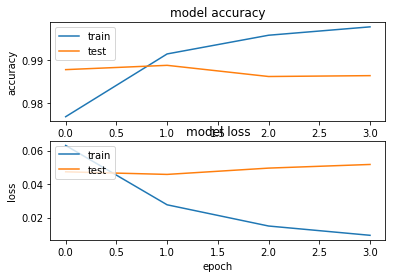

In [15]:
#可视化学习曲线
show_learning_curve(history)

In [16]:
#预测结果
predict_on_model(X_test, model, model_h5file_tunig1, pred_file_tuning1)

12500/12500 [==============================] - 24s 2ms/step


  0%|          | 0/12500 [00:00<?, ?it/s]/home/ubuntu/dogs-and-cats/helper.py:151: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(i, 'label', y_test[i])
100%|██████████| 12500/12500 [00:00<00:00, 140058.13it/s]


## 冻结前142层，再训练
放开conv4_x以后的层，不含conv4_x

142 activation_40

In [17]:
# 设置需要冻结的层数
lock_layers(model, locked_layer_nums=142)

0 input_1
1 lambda_1
2 conv1_pad
3 conv1
4 bn_conv1
5 activation_1
6 max_pooling2d_1
7 res2a_branch2a
8 bn2a_branch2a
9 activation_2
10 res2a_branch2b
11 bn2a_branch2b
12 activation_3
13 res2a_branch2c
14 res2a_branch1
15 bn2a_branch2c
16 bn2a_branch1
17 add_1
18 activation_4
19 res2b_branch2a
20 bn2b_branch2a
21 activation_5
22 res2b_branch2b
23 bn2b_branch2b
24 activation_6
25 res2b_branch2c
26 bn2b_branch2c
27 add_2
28 activation_7
29 res2c_branch2a
30 bn2c_branch2a
31 activation_8
32 res2c_branch2b
33 bn2c_branch2b
34 activation_9
35 res2c_branch2c
36 bn2c_branch2c
37 add_3
38 activation_10
39 res3a_branch2a
40 bn3a_branch2a
41 activation_11
42 res3a_branch2b
43 bn3a_branch2b
44 activation_12
45 res3a_branch2c
46 res3a_branch1
47 bn3a_branch2c
48 bn3a_branch1
49 add_4
50 activation_13
51 res3b_branch2a
52 bn3b_branch2a
53 activation_14
54 res3b_branch2b
55 bn3b_branch2b
56 activation_15
57 res3b_branch2c
58 bn3b_branch2c
59 add_5
60 activation_16
61 res3c_branch2a
62 bn3c_branch2a


In [18]:
model.load_weights(model_h5file_tunig1) 
adam = optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,             
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
#训练模型并保存在验证集上损失函数最小的权重
checkpoint = ModelCheckpoint(model_h5file_tunig2, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min') #如连续2个epoch,loss都没有没有下降,则停止训练
callbacks_list = [stopping,checkpoint]
history=model.fit(X_train, Y_train, batch_size=128, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=callbacks_list)

Train on 19944 samples, validate on 4986 samples
Epoch 1/20
19944/19944 [==============================] - 56s 3ms/step - loss: 0.0124 - acc: 0.9975 - val_loss: 0.0375 - val_acc: 0.9892

Epoch 00001: val_loss improved from inf to 0.03749, saving model to ResNet50-fine-tuning-2-v1.h5
Epoch 2/20
19944/19944 [==============================] - 52s 3ms/step - loss: 0.0073 - acc: 0.9987 - val_loss: 0.0351 - val_acc: 0.9900

Epoch 00002: val_loss improved from 0.03749 to 0.03511, saving model to ResNet50-fine-tuning-2-v1.h5
Epoch 3/20
19944/19944 [==============================] - 53s 3ms/step - loss: 0.0053 - acc: 0.9994 - val_loss: 0.0337 - val_acc: 0.9908

Epoch 00003: val_loss improved from 0.03511 to 0.03366, saving model to ResNet50-fine-tuning-2-v1.h5
Epoch 4/20
19944/19944 [==============================] - 52s 3ms/step - loss: 0.0048 - acc: 0.9996 - val_loss: 0.0369 - val_acc: 0.9906

Epoch 00004: val_loss did not improve from 0.03366
Epoch 5/20
19944/19944 [=========================

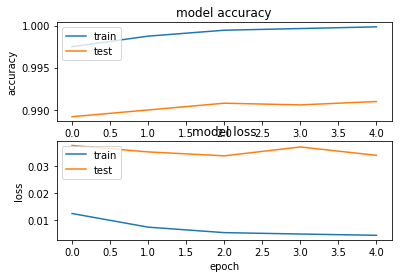

In [20]:
#可视化学习曲线
show_learning_curve(history)

In [21]:
#预测结果
predict_on_model(X_test, model, model_h5file_tunig2, pred_file_tuning2)

12500/12500 [==============================] - 28s 2ms/step


  0%|          | 0/12500 [00:00<?, ?it/s]/home/ubuntu/dogs-and-cats/helper.py:151: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(i, 'label', y_test[i])
100%|██████████| 12500/12500 [00:00<00:00, 139790.00it/s]


## 冻结前112层，再训练
放开conv4_x第3层以后的层，不含conv4_x的第3层  
112 activation_31

In [22]:
# 设置需要冻结的层数
lock_layers(model, locked_layer_nums=112)

0 input_1
1 lambda_1
2 conv1_pad
3 conv1
4 bn_conv1
5 activation_1
6 max_pooling2d_1
7 res2a_branch2a
8 bn2a_branch2a
9 activation_2
10 res2a_branch2b
11 bn2a_branch2b
12 activation_3
13 res2a_branch2c
14 res2a_branch1
15 bn2a_branch2c
16 bn2a_branch1
17 add_1
18 activation_4
19 res2b_branch2a
20 bn2b_branch2a
21 activation_5
22 res2b_branch2b
23 bn2b_branch2b
24 activation_6
25 res2b_branch2c
26 bn2b_branch2c
27 add_2
28 activation_7
29 res2c_branch2a
30 bn2c_branch2a
31 activation_8
32 res2c_branch2b
33 bn2c_branch2b
34 activation_9
35 res2c_branch2c
36 bn2c_branch2c
37 add_3
38 activation_10
39 res3a_branch2a
40 bn3a_branch2a
41 activation_11
42 res3a_branch2b
43 bn3a_branch2b
44 activation_12
45 res3a_branch2c
46 res3a_branch1
47 bn3a_branch2c
48 bn3a_branch1
49 add_4
50 activation_13
51 res3b_branch2a
52 bn3b_branch2a
53 activation_14
54 res3b_branch2b
55 bn3b_branch2b
56 activation_15
57 res3b_branch2c
58 bn3b_branch2c
59 add_5
60 activation_16
61 res3c_branch2a
62 bn3c_branch2a


In [27]:
model.load_weights(model_h5file_base) 
adam = optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=adam,             
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
#训练模型并保存在验证集上损失函数最小的权重
checkpoint = ModelCheckpoint(model_h5file_tunig3, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
stopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min') #如连续2个epoch,loss都没有没有下降,则停止训练
callbacks_list = [stopping,checkpoint]

history=model.fit(X_train, Y_train, batch_size=128, epochs=epochs, validation_split=0.2, shuffle=True, callbacks=callbacks_list)


Train on 19944 samples, validate on 4986 samples
Epoch 1/20
19944/19944 [==============================] - 65s 3ms/step - loss: 0.0641 - acc: 0.9768 - val_loss: 0.0353 - val_acc: 0.9888

Epoch 00001: val_loss improved from inf to 0.03531, saving model to ResNet50-fine-tuning-3-v1.h5
Epoch 2/20
19944/19944 [==============================] - 59s 3ms/step - loss: 0.0311 - acc: 0.9893 - val_loss: 0.0305 - val_acc: 0.9906

Epoch 00002: val_loss improved from 0.03531 to 0.03048, saving model to ResNet50-fine-tuning-3-v1.h5
Epoch 3/20
19944/19944 [==============================] - 59s 3ms/step - loss: 0.0180 - acc: 0.9956 - val_loss: 0.0293 - val_acc: 0.9910

Epoch 00003: val_loss improved from 0.03048 to 0.02931, saving model to ResNet50-fine-tuning-3-v1.h5
Epoch 4/20
19944/19944 [==============================] - 59s 3ms/step - loss: 0.0116 - acc: 0.9977 - val_loss: 0.0283 - val_acc: 0.9910

Epoch 00004: val_loss improved from 0.02931 to 0.02828, saving model to ResNet50-fine-tuning-3-v1.h5

In [ ]:
#可视化学习曲线
show_learning_curve(history)

In [ ]:
#预测结果
predict_on_model(X_test, model, model_h5file_tunig3, pred_file_tuning3)

## 备注说明
不知道什么缘故，最后两个CELL没有输出内容，但预测的过程肯定有跑过的，从后台主机上的文件时间可以看出，pred-ResNet50-fine-tuning-3-v1.csv已经生成了，而且时间上看也差不多是连续的（跟其他几个csv文件比）。  
因为是整理论文才发现这个问题，重跑的话，要花费不少时间，而且这个模型的权重文件正好被选中做为融合模型之一了，所以就没重跑。

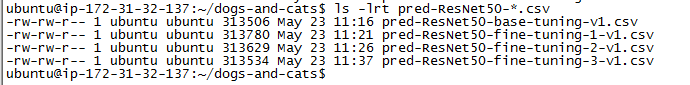